# 提取因子的封装函数

In [123]:
# 提取因子数据

#参数及工具函数部分
import pandas as pd
import numpy as np
from jqfactor import *
import warnings  
warnings.filterwarnings('ignore')

#获取数据主函数
#输入股票池、指标名称、开始日期、结束日期
#返回行标签为日期，列表签为股票名称的dataframe表格
def get_factor_data(stockPool, factor,date_start, date_end):
    
    #获取股票池函数
    def get_stock(stockPool, begin_date):
        if stockPool == 'HS300':#用于获取沪深300股票池
            stockList = get_index_stocks('000300.XSHG', begin_date)
        elif stockPool == 'ZZ500':#用于获取中证500股票池
            stockList = get_index_stocks('399905.XSHE', begin_date)
        elif stockPool == 'ZZ800':#用于获取中证800股票池
            stockList = get_index_stocks('399906.XSHE', begin_date)   
        elif stockPool == 'A':#用于获取全部A股股票池
            stockList = get_index_stocks('000002.XSHG', begin_date) + get_index_stocks('399107.XSHE', begin_date)
        else:#自定义输入股票池
            stockList = stockPool
        return stockList    
    
    #从财务库获取数据
    def get_factor_account_data(factor,stock, date):
        if factor in val:
            q = query(valuation).filter(valuation.code.in_(stock))
            df = get_fundamentals(q, date)
        elif factor in bal:
            q = query(balance).filter(balance.code.in_(stock))
            df = get_fundamentals(q, date)
        elif factor in cf:
            q = query(cash_flow).filter(cash_flow.code.in_(stock))
            df = get_fundamentals(q, date)
        elif factor in inc:
            q = query(income).filter(income.code.in_(stock))
            df = get_fundamentals(q, date)
        elif factor in ind:
            q = query(indicator).filter(indicator.code.in_(stock))
            df = get_fundamentals(q, date)

        df.index = df['code']
        data = pd.DataFrame(index = df.index)
        data[date] = df[factor]

        return data
    
    def get_trade_days(start_date = date_start, end_date = date_end):
    
        pool = get_index_stocks('000016.XSHG')

        date_list = get_price(pool,start_date=date_start,end_date=date_end,fields=['close'])['close'].index
        return date_list
    
    
    #获取日期列表
    date_list = get_trade_days(start_date = date_start, end_date = date_end)
    #空df预备存储数据，data_ret是返回数据
    data_ret = pd.DataFrame(data = [], columns = ['date','asset','factor'])
    
    #获取五张财务基础所有指标名称
    val = get_fundamentals(query(valuation).limit(1)).columns.tolist()
    bal = get_fundamentals(query(balance).limit(1)).columns.tolist()
    cf = get_fundamentals(query(cash_flow).limit(1)).columns.tolist()
    inc = get_fundamentals(query(income).limit(1)).columns.tolist()
    ind = get_fundamentals(query(indicator).limit(1)).columns.tolist()
    all_columns = val+bal+cf+inc+ind
    
    
    # 判断相应的股票池
    # 如果stockpool是字母，则按照字母提取
    # 如果stockpool是数组，则直接赋值字母
    # 确定相应的股票池
    if isinstance(stockPool,list):
        all_stocks = stockPool
    else:
        all_stocks = get_stock(stockPool, date_end)

    #循环时间列表获取指标数据
    for date in date_list:
        
        data_temp = pd.DataFrame(data = [],columns = ['date','asset','factor'])

        #获取股票池
        #获取因子数据
        if factor in all_columns: #可以从财务库直接取到因子值的因子
            data_temp['factor'] = get_factor_account_data(factor,all_stocks, date).iloc[:,0]
        
        
        # 改造成alphalen需要格式
        # 确定资产名称
        data_temp['asset'] =  get_factor_account_data(factor,all_stocks, date).index
        
        # 确定日期
        data_temp['date'] =  np.array([date for i in range(0,data_temp.shape[0])])
        
        
        # 删除原先的索引
        data_temp = data_temp.reset_index()
        data_temp = data_temp.drop(['code'],axis=1)
        
        data_ret = pd.concat([data_ret, data_temp], axis = 0) 
        

        # 如果不需要则进行正常的数据合并
        #         data = pd.concat([data, data_temp], axis = 0) 

    # 确定 multi_index
    data_ret = data_ret.set_index(['date','asset'])
    return data_ret



# 去极值、中性化、标准化的封装函数

In [124]:
from sklearn.linear_model import LinearRegression

def mad(factor):
    # 3倍中位数去极值
    # 确定输入变量
    factor = np.array(factor)
        
    # 求出因子值的中位数
    med = np.median(factor)

    # 求出因子值与中位数的差值，进行绝对值
    mad = np.median(abs(factor - med))

    # 定义几倍的中位数上下限
    high = med + (3 * 1.4826 * mad)
    low = med - (3 * 1.4826 * mad)

    # 替换上下限以外的值
    factor = np.where(factor > high, high, factor)
    factor = np.where(factor < low, low, factor)
    
    # 因为np处理后会将数据由[x]变为[[x]]的数据，所以进行处理
    ret = factor
    return ret


def stand(factor):
    factor = np.array(factor)
    mean = factor.mean()
    std = factor.std()
    return (factor - mean)/std
    
# factor1：主参数，一般为需要被中性化的参数
# factor2：被动参数，一般作为参考想象，一般是市值作为中性化的参考参数
def neutral(factor1,factor2):
    # 统一类型
    factor1 = np.array(factor1)
    factor2 = np.array(factor2)
    
    # 去除0值
    factor1[np.isnan(factor1)] = 0
    factor2[np.isnan(factor2)] = 0

    
    # 根据LinearRegression的要求需要将参数做reshape的处理
    # python 3 在这里有一错误，所以要增加values的设置
    # x = factor2.values.reshape(-1,1)
    # y = factor1.values.reshape(-1,1)
    
    # 注意：以下代码为np的reshape（pandas的reshape与np的reshape略有不同）
    x = np.reshape(factor2,(-1,1))
    y = np.reshape(factor1,(-1,1))
    try:
        # 建立回归方程并预测
        lr = LinearRegression()
        lr.fit(x, y)
        y_predict = lr.predict(x)
    except:
        print("出错，未进行中性化")
        # 如果出错，则预测值统一列为0，保持原值
        y_predict = 0
        
    # 去除线性的关系，留下误差作为该因子的值
    res = y - y_predict   
    
    # 因为np处理后会将数据由[x]变为[[x]]的数据，所以进行处理
    return [d[0] for d in res]

# 在上面Neutral函数的基础上，对原始数据中性化

- 逐日期进行，对每个截断面数据进行操作
- 每个日期按照去极值、市值中性化、标准化的流程进行

In [125]:
from datetime import datetime

from sklearn.linear_model import LinearRegression


def neutral_data_by_market_cap(factor_input,if_market_neutral):
    
    factor_data = factor_input
    
    # 遍历每一个日期
    for date_i in set([index[0] for index, row in factor_data.iterrows()]):
    # for date_i in [datetime.strptime('2016-01-11', '%Y-%m-%d')]:

        # print(date_i)
        # 临时赋值使用的factor_temp_pd
        factor_temp_np = pd.DataFrame()
        factor_refer = pd.DataFrame()


        # 提取每一个日期的股票编码列表
        sec_list = []
        sec_list = list(factor_data.loc[(date_i)].index)

        factor_temp_np = np.array(factor_data.loc[(date_i),'factor'])

        # 去极值
        factor_temp_np = mad(factor_temp_np)

        # 如果需要市值中性化，则进行中性化
        if if_market_neutral:
            # 中性化 
            # 提取参考的市值因子
            factor_refer = get_factor_data(sec_list,'market_cap',date_i,date_i)
            factor_refer = factor_refer.loc[(date_i),'factor']
            
            factor_temp_np = neutral(factor_temp_np,factor_refer)
            # 标准化
            factor_temp_np = stand(factor_temp_np)
        # 不需要市值中性化的话
        else:
            factor_temp_np = stand(factor_temp_np)
        
        # 赋值
        factor_data.loc[(date_i),'factor'] = np.array(factor_temp_np)
        
    return factor_data

In [126]:
# IC分析
from alphalens.tears import create_information_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns

# alphalen数据清理
from alphalens.utils import get_clean_factor_and_forward_returns


# 关闭告警
import warnings
warnings.filterwarnings("ignore")

# 设置因子池、倒置控制数组
factor_pool = ['pb_ratio','inc_return','market_cap']
if_reverse = [1,0,0]

# 设置起始、终止日期
begin_date = '2018-10-10'
end_date = '2019-10-20'


factor_total_pd = pd.DataFrame()


# 开始财务因子循环
for i in range(0,len(factor_pool)):
# for i in range(0,1):

    # 因子赋值
    factor_i = factor_pool[i]
    if_reverse_i = if_reverse[i]
    
    print("$$处理因子值：%s"%str(factor_i))
    
    
    # 提取因子
    # 示例，获取沪深300成分股在2019年前两个月的市盈率数据
    # 注意：每次只能提取1个因子
    factor_data = get_factor_data('HS300', factor_i,begin_date, end_date)
    factor_data = factor_data.fillna(0)
    
    # 确定是否取倒数
    if if_reverse_i:
        factor_data['factor'] = 1/factor_data['factor']
        print("--取倒数")
    print("--提取因子完成")

        
    # 去极值、中性化、标准化
    # 第二个参数“1”/“0”表示 需要/不需要 进行市值中性化
    factor_data = neutral_data_by_market_cap(factor_data,0)
    
    print("--数据中性化完成")

    # 数据合并
    # 更改列名
    factor_data.rename(columns={'factor':factor_i}, inplace = True)
    
    factor_total_pd = pd.concat([factor_total_pd,factor_data],axis = 1)
    print("--数据合并完成")



$$处理因子值：pb_ratio
--取倒数
--提取因子完成
--数据中性化完成
--数据合并完成
$$处理因子值：inc_return
--提取因子完成
--数据中性化完成
--数据合并完成
$$处理因子值：market_cap
--提取因子完成
--数据中性化完成
--数据合并完成


# 获取技术因子，并进行中性化等操作


In [127]:
# 设置因子池、倒置控制数组
factor_pool = ['EMAC10']
if_reverse = [0]

# 设置起始、终止日期
# 与上面的日期一直

factor_total_tec_pd = pd.DataFrame()

# 开始财务因子循环
for i in range(0,len(factor_pool)):
# for i in range(0,1):

    # 因子赋值
    factor_i = factor_pool[i]
    if_reverse_i = if_reverse[i]
    
    print("$$处理因子值：%s"%str(factor_i))
    
    
    # 提取因子
    # 示例，获取沪深300成分股在2019年前两个月的市盈率数据
    # 注意：每次只能提取1个因子
    stock_pool = get_index_stocks('000300.XSHG', end_date)
    
    
    factor_data_tec = pd.DataFrame()
    factor_data_factor_raw = get_factor_values(stock_pool, [factor_i], start_date =begin_date, end_date = end_date)[factor_i]
    for row_i in range(0,factor_data_factor_raw.shape[0]):
     
        # 初始化清零
        factor_data_temp = pd.DataFrame()
        
        # 关键函数赋值
        factor_data_temp['factor']  = factor_data_factor_raw.iloc[row_i,:].T
        factor_data_temp['date']  = np.array([factor_data_factor_raw.index[row_i] for i in range(0,factor_data_factor_raw.shape[1])])
        factor_data_temp['asset']  = factor_data_temp.index
        
        # 删除index
        factor_data_temp = factor_data_temp.reset_index()
        factor_data_temp = factor_data_temp.drop(['code'],axis=1)
        
        # 如果不需要则进行正常的数据合并
        factor_data_tec = pd.concat([factor_data_tec, factor_data_temp], axis = 0) 
        
    
    # 确定 multi_index
    factor_data_tec = factor_data_tec.set_index(['date','asset'])

    # 确定是否取倒数
    if if_reverse_i:
        factor_data_tec['factor'] = 1/factor_data_tec['factor']
        print("--取倒数")
    print("--提取因子完成")

    factor_data_tec = factor_data_tec.fillna(1)
    # 去极值、中性化、标准化
    # 第二个参数“1”/“0”表示 需要/不需要 进行市值中性化
    factor_data_tec = neutral_data_by_market_cap(factor_data_tec,0)
    
    print("--数据中性化完成")

    
    # 数据合并
    # 更改列名
    factor_data_tec.rename(columns={'factor':factor_i}, inplace = True)
    
    factor_total_tec_pd = pd.concat([factor_total_tec_pd,factor_data_tec],axis = 1)
    factor_total_tec_pd = factor_total_tec_pd.fillna(1)
    
    print("--数据合并完成")


$$处理因子值：EMAC10
--提取因子完成
--数据中性化完成
--数据合并完成


In [128]:
factor_total_tec_pd

EMAC10
date       asset                
2018-10-10 000001.XSHE -0.481243
           000002.XSHE  1.875149
           000063.XSHE  1.300509
           000069.XSHE  0.513806
           000100.XSHE -0.121000
           000157.XSHE -0.160438
           000166.XSHE -0.085992
           000333.XSHE  0.436275
           000338.XSHE -1.208651
           000402.XSHE  0.318593
           000408.XSHE  0.192408
           000413.XSHE  0.083508
           000415.XSHE -0.526812
           000423.XSHE -0.128990
           000425.XSHE -0.164394
           000538.XSHE  1.081326
           000553.XSHE -0.527326
           000568.XSHE  1.979104
           000596.XSHE  1.510674
           000625.XSHE -0.556638
           000627.XSHE  0.047749
           000629.XSHE -2.536523
           000630.XSHE -0.982821
           000651.XSHE -0.384210
           000656.XSHE  0.671953
           000661.XSHE -0.130691
           000671.XSHE  0.759651
           000703.XSHE -0.165185
           000709.XSHE -0.670996
           000725.XSHE  0.655260
...                          ...
2019-10-18 601828.XSHG  0.513997
           601838.XSHG -0.523082
           601857.XSHG -0.129247
           601877.XSHG  0.405465
           601878.XSHG  0.456066
           601881.XSHG  0.864891
           601888.XSHG -0.687841
           601898.XSHG  0.399317
           601899.XSHG  0.715123
           601901.XSHG  0.547904
           601919.XSHG  1.213705
           601933.XSHG -0.029654
           601939.XSHG -0.832408
           601985.XSHG  0.121581
           601988.XSHG -0.702832
           601989.XSHG  0.768939
           601992.XSHG  0.110420
           601997.XSHG  0.059300
           601998.XSHG -1.010362
           603019.XSHG  0.615056
           603156.XSHG  0.034519
           603160.XSHG  0.765865
           603259.XSHG -1.065077
           603260.XSHG  0.567860
           603288.XSHG  0.247704
           603799.XSHG  1.770644
           603833.XSHG -1.316331
           603858.XSHG -0.508658
           603986.XSHG  2.531841
           603993.XSHG  0.682067

[75000 rows x 1 columns]

# 财务因子与技术因子合并

In [129]:
factor_total_pd = pd.concat([factor_total_pd,factor_data_tec],axis=1)
factor_total_pd


pb_ratio  inc_return  market_cap    EMAC10
date       asset                                                  
2018-10-10 000001.XSHE  1.638084   -0.109960    1.715703 -0.481243
           000002.XSHE -0.110124    1.073461    1.715703  1.875149
           000063.XSHE -0.691249   -2.866352    0.310954  1.300509
           000069.XSHE  1.374348   -0.755115   -0.293548  0.513806
           000100.XSHE  0.678124   -0.659678   -0.624682 -0.121000
           000157.XSHE  1.921395   -0.881092   -0.859815 -0.160438
           000166.XSHE  0.349286   -0.655860    1.081679 -0.085992
           000333.XSHE -0.732038    2.317962    1.715703  0.436275
           000338.XSHE -0.124927    1.000929    0.234811 -1.208651
           000402.XSHE  2.548059   -0.892544   -1.089830  0.318593
           000408.XSHE -0.730010    0.756610   -0.997591  0.192408
           000413.XSHE  1.316778   -0.743663   -0.818514  0.083508
           000415.XSHE  2.308001   -0.422994   -0.991006 -0.526812
           000423.XSHE -0.665961   -0.575693   -0.823181 -0.128990
           000425.XSHE  0.718776   -0.453534   -0.812237 -0.164394
           000538.XSHE -0.870980    0.180169    0.379925  1.081326
           000553.XSHE  0.436915   -0.663495   -0.818698 -0.527326
           000568.XSHE -0.940958    0.943667    0.046076  1.979104
           000596.XSHE -1.053749    0.424488   -0.610503  1.510674
           000625.XSHE  2.164286   -1.415540   -0.708977 -0.556638
           000627.XSHE  0.200663   -0.598598   -0.816143  0.047749
           000629.XSHE -1.138392    2.634980   -0.648605 -2.536523
           000630.XSHE  0.576153   -0.850552   -1.012666 -0.982821
           000651.XSHE -0.613676    2.634980    1.715703 -0.384210
           000656.XSHE  0.164136   -0.312286   -0.917727  0.671953
           000661.XSHE -1.209524    1.470480   -0.583945 -0.130691
           000671.XSHE  0.359552    0.260337   -1.010428  0.759651
           000703.XSHE -0.602003   -0.266477   -0.603583 -0.165185
           000709.XSHE  2.336122   -0.125230   -0.721941 -0.670996
           000725.XSHE  0.713939   -1.251388    1.255039  0.655260
...                          ...         ...         ...       ...
2019-10-18 601828.XSHG  1.367984   -0.411015   -0.661863  0.513997
           601838.XSHG  1.235551    0.375381   -0.835595 -0.523082
           601857.XSHG  1.339098   -0.678815    1.758698 -0.129247
           601877.XSHG -0.272273    1.047006   -0.509837  0.405465
           601878.XSHG -0.269207   -0.653310   -0.865348  0.456066
           601881.XSHG  0.123704   -0.593799    0.751136  0.864891
           601888.XSHG -1.246101    0.834466    1.758698 -0.687841
           601898.XSHG  2.354251   -0.257986   -0.158498  0.399317
           601899.XSHG -0.252913   -0.317498    0.058300  0.715123
           601901.XSHG  0.264271   -1.048633   -0.315545  0.547904
           601919.XSHG -0.198968   -0.517285   -0.269197  1.213705
           601933.XSHG -0.900634   -0.912608    0.289336 -0.029654
           601939.XSHG  1.297912    0.341375    1.758698 -0.832408
           601985.XSHG -0.020862   -0.189974    0.218289  0.121581
           601988.XSHG  2.258274    0.269111    1.758698 -0.702832
           601989.XSHG  0.269629   -0.972119    1.058818  0.768939
           601992.XSHG  1.654338    0.188346   -0.705843  0.110420
           601997.XSHG  1.351406    0.337124   -0.885933  0.059300
           601998.XSHG  2.269870   -0.117880    1.758698 -1.010362
           603019.XSHG -1.183628   -0.423767   -0.833801  0.615056
           603156.XSHG -0.534721   -0.508783   -0.858798  0.034519
           603160.XSHG -1.355152    2.340663    0.341746  0.765865
           603259.XSHG -1.186670   -0.083704    1.516933 -1.065077
           603260.XSHG -0.755395   -0.113460   -0.891773  0.567860
           603288.XSHG -1.377495    2.232976    1.758698  0.247704
           603799.XSHG -0.748353   -1.584233   -0.929698  1.770644
           603833.XSHG -1.087815    1.582605   -0.453938 -1.316331
    

In [130]:
factor_total_pd['factor'] = 0
for col in factor_pool:
    factor_total_pd['factor'] = factor_total_pd[col] + factor_total_pd['factor'] 

In [131]:
factor_total_pd

pb_ratio  inc_return    ...       EMAC10    factor
date       asset                                ...                       
2018-10-10 000001.XSHE  1.638084   -0.109960    ...    -0.481243 -0.481243
           000002.XSHE -0.110124    1.073461    ...     1.875149  1.875149
           000063.XSHE -0.691249   -2.866352    ...     1.300509  1.300509
           000069.XSHE  1.374348   -0.755115    ...     0.513806  0.513806
           000100.XSHE  0.678124   -0.659678    ...    -0.121000 -0.121000
           000157.XSHE  1.921395   -0.881092    ...    -0.160438 -0.160438
           000166.XSHE  0.349286   -0.655860    ...    -0.085992 -0.085992
           000333.XSHE -0.732038    2.317962    ...     0.436275  0.436275
           000338.XSHE -0.124927    1.000929    ...    -1.208651 -1.208651
           000402.XSHE  2.548059   -0.892544    ...     0.318593  0.318593
           000408.XSHE -0.730010    0.756610    ...     0.192408  0.192408
           000413.XSHE  1.316778   -0.743663    ...     0.083508  0.083508
           000415.XSHE  2.308001   -0.422994    ...    -0.526812 -0.526812
           000423.XSHE -0.665961   -0.575693    ...    -0.128990 -0.128990
           000425.XSHE  0.718776   -0.453534    ...    -0.164394 -0.164394
           000538.XSHE -0.870980    0.180169    ...     1.081326  1.081326
           000553.XSHE  0.436915   -0.663495    ...    -0.527326 -0.527326
           000568.XSHE -0.940958    0.943667    ...     1.979104  1.979104
           000596.XSHE -1.053749    0.424488    ...     1.510674  1.510674
           000625.XSHE  2.164286   -1.415540    ...    -0.556638 -0.556638
           000627.XSHE  0.200663   -0.598598    ...     0.047749  0.047749
           000629.XSHE -1.138392    2.634980    ...    -2.536523 -2.536523
           000630.XSHE  0.576153   -0.850552    ...    -0.982821 -0.982821
           000651.XSHE -0.613676    2.634980    ...    -0.384210 -0.384210
           000656.XSHE  0.164136   -0.312286    ...     0.671953  0.671953
           000661.XSHE -1.209524    1.470480    ...    -0.130691 -0.130691
           000671.XSHE  0.359552    0.260337    ...     0.759651  0.759651
           000703.XSHE -0.602003   -0.266477    ...    -0.165185 -0.165185
           000709.XSHE  2.336122   -0.125230    ...    -0.670996 -0.670996
           000725.XSHE  0.713939   -1.251388    ...     0.655260  0.655260
...                          ...         ...    ...          ...       ...
2019-10-18 601828.XSHG  1.367984   -0.411015    ...     0.513997  0.513997
           601838.XSHG  1.235551    0.375381    ...    -0.523082 -0.523082
           601857.XSHG  1.339098   -0.678815    ...    -0.129247 -0.129247
           601877.XSHG -0.272273    1.047006    ...     0.405465  0.405465
           601878.XSHG -0.269207   -0.653310    ...     0.456066  0.456066
           601881.XSHG  0.123704   -0.593799    ...     0.864891  0.864891
           601888.XSHG -1.246101    0.834466    ...    -0.687841 -0.687841
           601898.XSHG  2.354251   -0.257986    ...     0.399317  0.399317
           601899.XSHG -0.252913   -0.317498    ...     0.715123  0.715123
           601901.XSHG  0.264271   -1.048633    ...     0.547904  0.547904
           601919.XSHG -0.198968   -0.517285    ...     1.213705  1.213705
           601933.XSHG -0.900634   -0.912608    ...    -0.029654 -0.029654
           601939.XSHG  1.297912    0.341375    ...    -0.832408 -0.832408
           601985.XSHG -0.020862   -0.189974    ...     0.121581  0.121581
           601988.XSHG  2.258274    0.269111    ...    -0.702832 -0.702832
           601989.XSHG  0.269629   -0.972119    ...     0.768939  0.768939
           601992.XSHG  1.654338    0.188346    ...     0.110420  0.110420
           601997.XSHG  1.351406    0.337124    ...     0.059300  0.059300
           601998.XSHG  2.269870   -0.117880    ...    -1.010362 -1.010362
           603019.XSHG -1.183628   -0.423767    ...     0.615056  0.615056
           603156.XSHG -0.534721   -0.508783    .

Dropped 8.2% entries from factor data (8.2% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.
Information Analysis


,1,5,10,20
IC Mean,0.026,0.039,0.042,0.063
IC Std.,0.184,0.171,0.154,0.148
Risk-Adjusted IC,0.140,0.225,0.275,0.423
t-stat(IC),2.120,3.406,4.171,6.416
p-value(IC),0.035,0.001,0.000,0.000
IC Skew,-0.033,0.141,0.175,0.340
IC Kurtosis,-0.108,-0.137,-0.014,0.210


<Figure size 432x288 with 0 Axes>

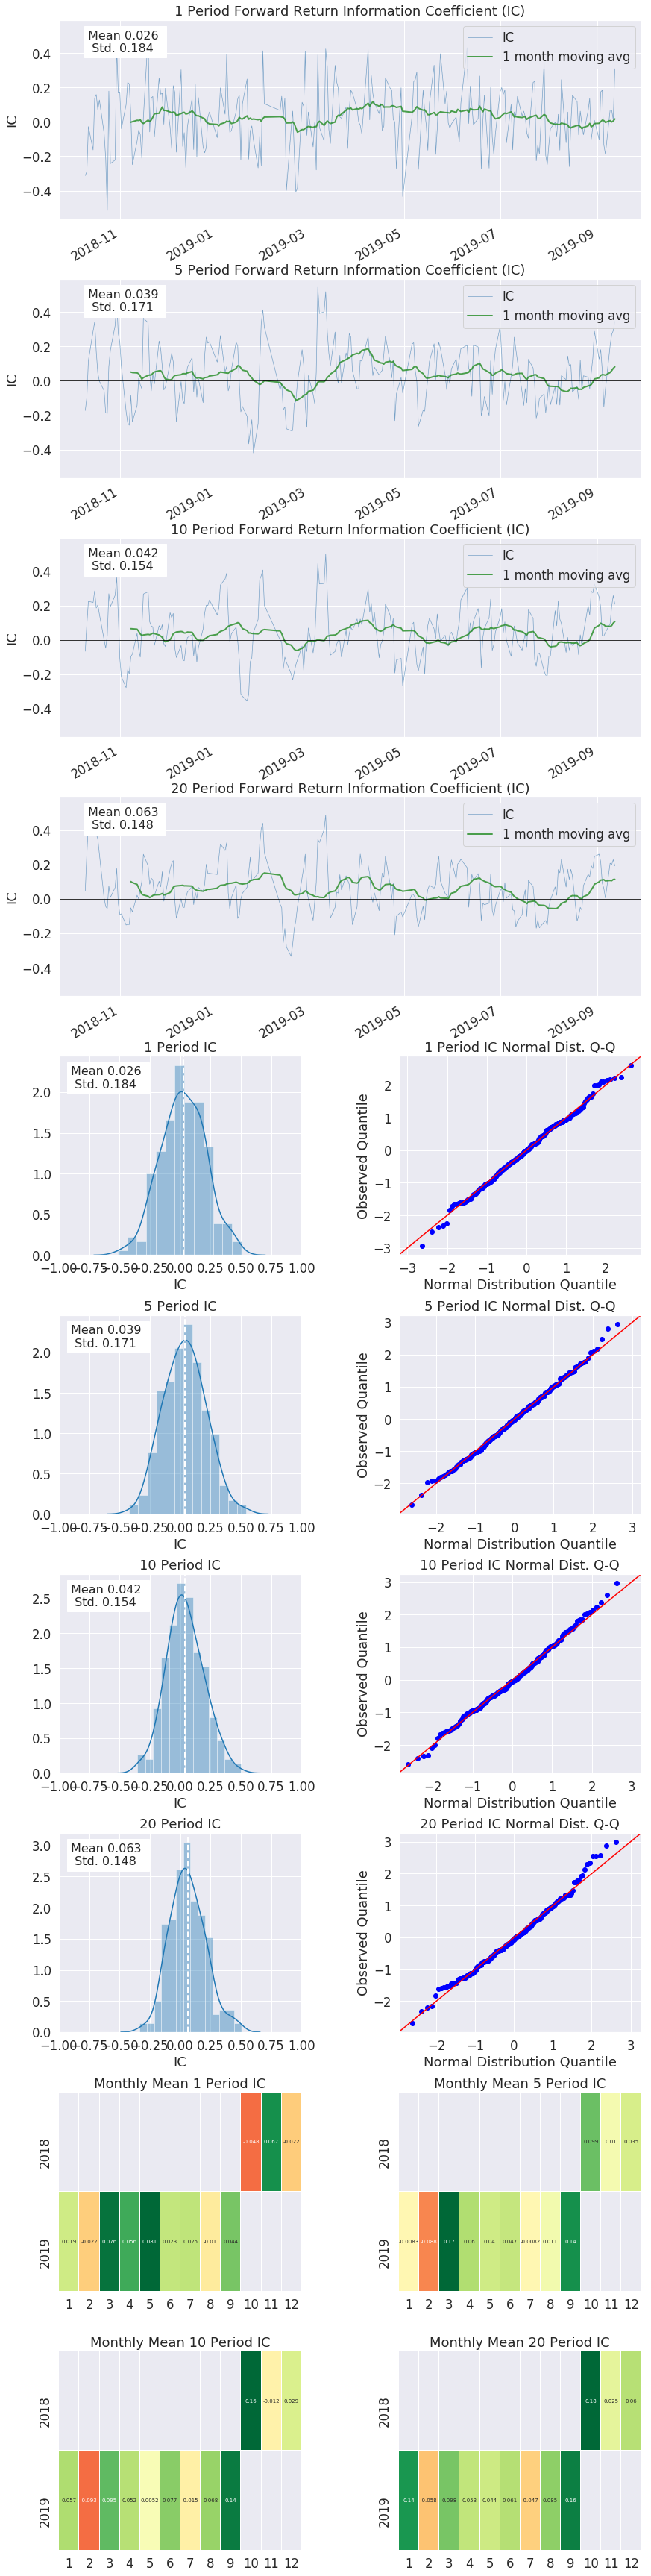

In [133]:
# 严格意义应在循环外处理
# 此处仅为示例
# 提取价格数据
all_stocks = list(set([index[1] for index, row in factor_data.iterrows()]))
price_data = get_price(all_stocks,start_date=begin_date , end_date = end_date,fields=['close'])['close']


# 数据清洗
merged_data = get_clean_factor_and_forward_returns(
  factor=factor_total_pd['factor'], 
  prices=price_data,
  periods = [1,5,10,20] 
)

create_information_tear_sheet(merged_data)